#   How do we fit a function to data?

In [5]:
import fastbook
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')
plt.rc('figure', dpi=90)


def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

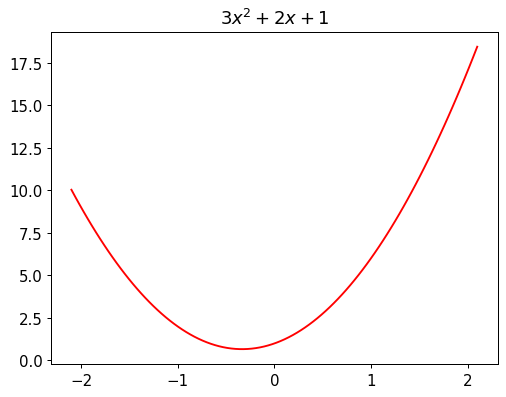

In [6]:
#create a quadratic function
def f(x):
    return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

lets assume that this is tnot the function graph that we are tring to find. Lets try to recreate the function from some data

In [7]:
def quad(a, b, c, x):
    return a*x**2 + b*x + c

In [8]:
quad(3,2,1,1.5)

10.75

Now, we might want to create lots and lots of different quadratics to test them out and see which ones are the best fit
We will use the `functools` library and the `partial module` to fix values of `a`, `b`, `c` to picka particular quadratic

In [9]:
from functools import partial
def mk_quad(a,b,c):
    return partial(quad, a,b,c)

In [10]:
f = mk_quad(3,2,1)
f(1.5)

10.75

this creates a quadratic function with coefficients `3,2,1`. And if we pass in `1.5` we get the same exact value as we did before.

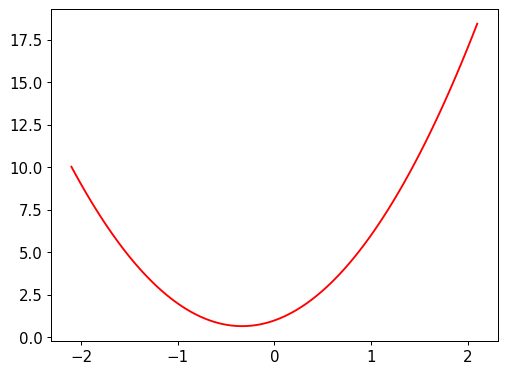

In [11]:
plot_function(f)

## Functions that have noise

Not every data will follow a specified line or shape . expect that data will get as random as possible

couple of functions to add some noise

In [12]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x, scale):
    return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add):
    return x * (1+noise(x,mult)) + noise(x,add)

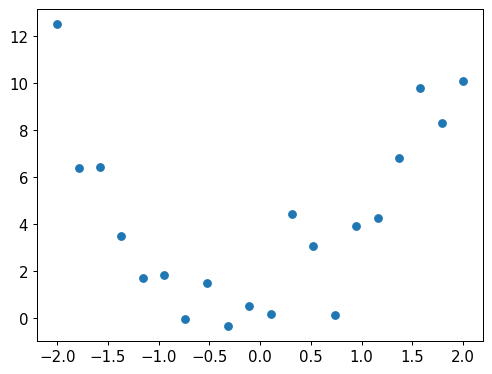

In [13]:
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y);

This code defines two functions, `noise` and `add_noise`, and uses them to generate noisy data for a given function `f(x)`.

The noise function generates random noise with a given scale using numpy's normal function.
The seed is used to generate random numbers.

The `add_noise` function adds noise to the input `x` by multiplying it with `1+noise(x,mult)` and adding `noise(x,add)`. Here, `mult` and `add` are the scale of the noise to be added in the multiplicative and additive forms, respectively.

Then, the code uses the `add_noise` function to add noise to the output of f(x), and stores the result in y. Finally, it plots the noisy data points using `plt.scatter(x,y)`.

`torch.linspace` creates a tensor ie a vector that goes from -2 to 2 in equal steps

lets create a plot_quad function theat we will use to plot our random data

In [14]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a, b, c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

`@interact` is used to interact with the graph by sliding the co-ordinates of the graph

but we can not do this for data models with millions of parameters trying to standardize the graphs. So lets use something better.

In [15]:
def mse(preds, acts):
    return ((preds-acts)**2).mean()

we want to check whethe rour plot is getting better or worse. this is called a loss function. the most used , simple and common loss function used is the mean squared error.
` return ((preds-acts)**2).mean()` we are taking predictions minus actuals squared, then gatting the mean.

In [16]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x,y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

as you can see, we have replaced `mk_quad` with f in the last line, added a `loss` variable that calls the `mse` function and placed it inside the `title` property in the `plot_function`.
`f(x)` are the values we `pred`ict and `y` are our `act`ual values.
remember that `mk_quad` is a function that creates our quadratic equation

as you can see, we adjusted our `MSE` from a `33` to a `2.54`. remember that a low `MSE` is a good `MSE`.

But doing all that is tedious! lets try a faster way bu using `derivatives`. Derivatives answer the question, if ypu increase the input, does the output increase or decrease? and by how much(`slope/gradient`)

In [17]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

`def quad_mse(params):` create a function that accepts params as inputs
    `f = mk_quad(*params)` we create a quadratic, passing in the parameters `a,b,c`. the `*` takes in the parameters and spreads them out into `a,b,c` variables to be stored
    `return mse(f(x), y)`w return our MSE with our predictions `f(x)` vs our actuals `y`

In [18]:
quad_mse([1.5,1.5,1.5])

tensor(5.8336, dtype=torch.float64)

we solved it!

In [19]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

`abc = torch.tensor([1.5, 1.5, 1.5])` weve placed a, band c in a 1-dimensional tensor ie a rank-1 tensor.

`abc.requires_grad_()` we now tell pytorch to calculate the gradient of these numbers whenever we use tham in a calculation

In [20]:
loss = quad_mse(abc)
loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

the `grad_fn=<MeanBackward0>` can be used to calculate our gradients

In [21]:
loss.backward()

`loss.backward()` tells pytorch to go ahead and calculate the gradient for us

In [22]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

`tensor([-10.9887,  -2.1225,  -4.0015])` tells us that if we increase a, the loss will go down, if we increase b, the loss will go down but slightly, same as c.
oh, these are the gradients

In [23]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=5.49


`with torch.no_grad():`
    `abc -= abc.grad*0.01`
   ` loss = quad_mse(abc)`

`print(f'loss={loss:.2f}')`

this is a function that subtracts `gradient*0.01` from our value `abc` ie `-10.9887-(-10.9887*0.01)`

In [24]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward
    with torch.no_grad():
        abc -= abc.grad*0.01
    print(f'step={i};   loss={loss:.2f}')

step=0;   loss=5.49
step=1;   loss=5.17
step=2;   loss=4.88
step=3;   loss=4.62
step=4;   loss=4.38


In [25]:
abc

tensor([1.8085, 1.3292, 1.5661], requires_grad=True)

This is what we call optimization. optimization is built on the principle of gradient descent.

##  rectified Linear Unit

In [26]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

`def rectified_linear(m,b,x):` 
`y = m*x+b` linear function of a line
`return torch.clip(y, 0.)` takes anything negative to zero

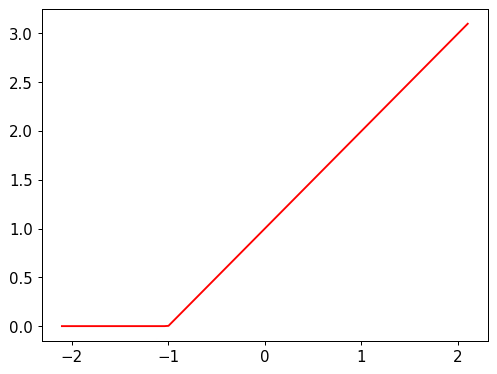

In [27]:
plot_function(partial(rectified_linear, 1, 1))

Lets make the plot function interactive using `@interact`

In [28]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

`plot_function(partial(rectified_linear, m, b), ylim=(-1,4))` we are using ylim to set the y limits

Now , why is this interesting? We can take this `relu` and create a double relu ie adding two rectified linear functions together

In [29]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

In [30]:
@interact(m1=1.5,b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1,b1,m2,b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=1.5, description='m1', max=4.5, min=-1.5), FloatSlider(value=-1.5, des…

And we are done!

in short what deep learning entails is using a gradient decscent function to set some parameters to make a wiggly function which is bassically the addition of rectified linear units to match your data.

## Matrix Multiplication

cool site [matrixmultiplication.xyz]

we will be using matrix multiplication. If the answer has any negatives , we will have to convert them to zeros
![My Image](matrixmultiplication.PNG)


we will use this in neural network creations.
also note that gpu's are really good in matrix multiplication because they have special cores cllled tensor cores that are used to do only one thing ie, multiply two four by four matrices.

## Overfit

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x,y)
    plt.scatter(x,y)
    plot_function(model.predict)
    

this function allows us to pass in the degree of a polynomial

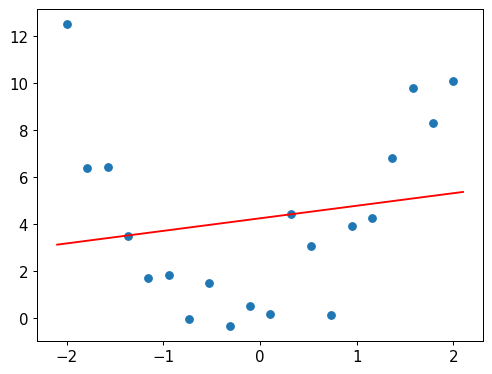

In [32]:
plot_poly(1)

sklearn is used for classic machine learning methods like linear regression. so here we are doing polynomial regresssionon out plot of data.

what happens if we fit a 10 degree polynomial into our scattered graph?

as you can see, the graph is tying really hard to get to all the point, even he points that can be considered noise!This is what we term as overfit

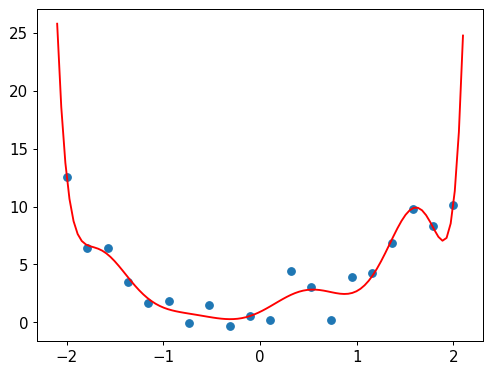

In [33]:
plot_poly(10)

overfitting is actually very hard to recognize since the training data are close to one another

lets try to fit a quadratic

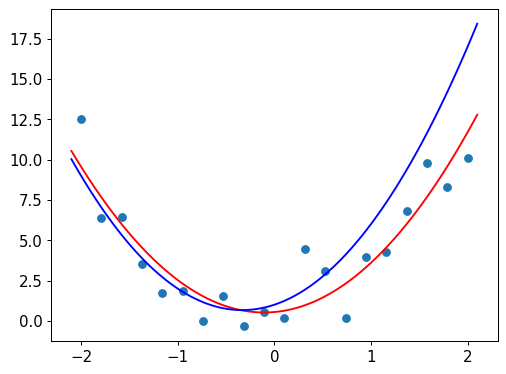

In [34]:
plot_poly(2) #fit line
plot_function(f, color='b') #real line

so how do we tell if we have an overfit or an underfit?
1. take original dataset and remove 20% of the points
2. fit using only the points we removed
3. Measure how good the fit is using the points removed

the data we removed and dont let the model see is called the validation set